In [191]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import norm

### a) Escolha cinco açõoes para analise: Voce deve selecionar cinco ações de sua preferencia e obter dados historicos de preços dessas ações, alem do ındice que as compõe.

In [2]:
acoes = ['CSCO', 'AMD', 'KO', 'AAPL', 'BLK', '^GSPC'] 

In [3]:
acoes_df = pd.DataFrame()

for acao in acoes:
    acoes_df[acao] = yf.download(acao, start='2012-01-01',  end='2023-07-31')['Close']
acoes_df.index = acoes_df.index.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
acoes_df.reset_index(inplace=True)
acoes_df.head()

Date       CSCO   AMD         KO       AAPL         BLK        ^GSPC
0  2012-01-03  18.629999  5.48  35.070000  14.686786  181.270004  1277.060059
1  2012-01-04  18.990000  5.46  34.849998  14.765714  179.960007  1277.300049
2  2012-01-05  18.920000  5.46  34.685001  14.929643  179.330002  1281.060059
3  2012-01-06  18.850000  5.43  34.465000  15.085714  179.130005  1277.810059
4  2012-01-09  18.969999  5.59  34.465000  15.061786  179.250000  1280.699951

### b) Realize uma anAalise grAafica descritiva temporal do preco das acoes: Voce deve plotar os dados de precos das acoes ao longo do tempo para cada uma das acoes selecionadas e para o ındice. Visualize como o preco das acoes mudou ao longo do tempo e identifique possıveis tendeencias.

#### Comentario: É possivel ver uma tendencia de crescimento no indice gradativamente. Com algumas quedas pontuais e posteriores recuperações

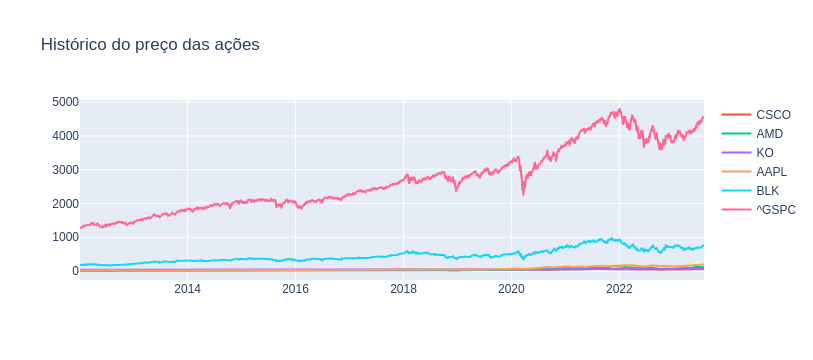

In [5]:
acoes = acoes_df.copy()
#acoes.drop(labels = ['^BVSP'], axis=1, inplace=True)
figura = px.line(title = 'Histórico do preço das ações')
for i in acoes.columns[1:]:
    figura.add_scatter(x = acoes["Date"] ,y = acoes[i], name = i)

figura.show()

### c) Realize uma analise grafica descritiva temporal do retorno das acoes: Voce deve calcular os retornos diarios das acoes e do ındice e plotar os dados de retorno ao longo do tempo para cada uma das acoes e para o ındice. Visualize como o retorno das acoes mudou ao longo do tempo e identifique possıveis padroes.

$ \mathbb{E}[R_i] = log \left( \frac{P_t}{P_{t-1}} \right) $


In [6]:
dataset = acoes_df.copy()
dataset.drop(labels = ['Date'], axis=1, inplace=True)
taxas_retorno = np.log(dataset / dataset.shift(1))
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
taxas_retorno = pd.concat([date, taxas_retorno], axis=1)

In [7]:
taxas_retorno.describe()

CSCO          AMD           KO         AAPL          BLK  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000   
mean      0.000353     0.001040     0.000198     0.000890     0.000483   
std       0.015914     0.035882     0.011117     0.018137     0.016850   
min      -0.147692    -0.277456    -0.101728    -0.137708    -0.146815   
25%      -0.006794    -0.016760    -0.004718    -0.007572    -0.007754   
50%       0.000408     0.000000     0.000434     0.000760     0.000704   
75%       0.007923     0.018914     0.005744     0.010420     0.008994   
max       0.125517     0.420617     0.062783     0.113157     0.126843   

             ^GSPC  
count  2910.000000  
mean      0.000439  
std       0.010782  
min      -0.127652  
25%      -0.003746  
50%       0.000594  
75%       0.005476  
max       0.089683

In [8]:
taxas_retorno_describe = taxas_retorno.describe()

In [9]:
taxas_retorno_describe.loc['mean']*100

CSCO     0.035333
AMD      0.103984
KO       0.019845
AAPL     0.089014
BLK      0.048262
^GSPC    0.043905
Name: mean, dtype: float64

In [10]:
taxas_retorno_describe.loc['std']*100

CSCO     1.591426
AMD      3.588187
KO       1.111671
AAPL     1.813711
BLK      1.684970
^GSPC    1.078204
Name: std, dtype: float64

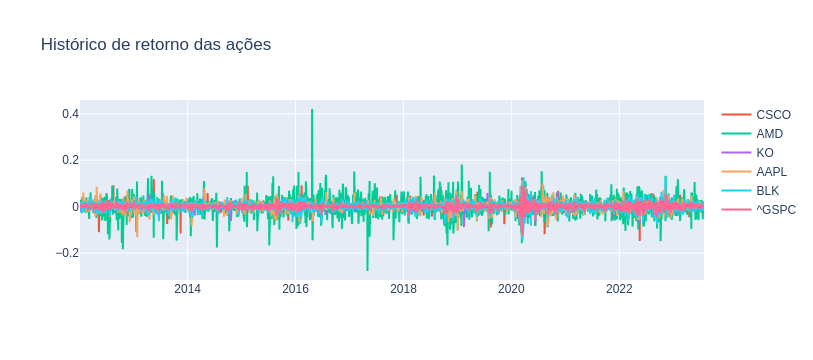

In [12]:
figura = px.line(title = 'Histórico de retorno das ações')
for i in taxas_retorno.columns[1:]:
      figura.add_scatter(x = taxas_retorno["Date"] ,y = taxas_retorno[i], name = i)

figura.show()

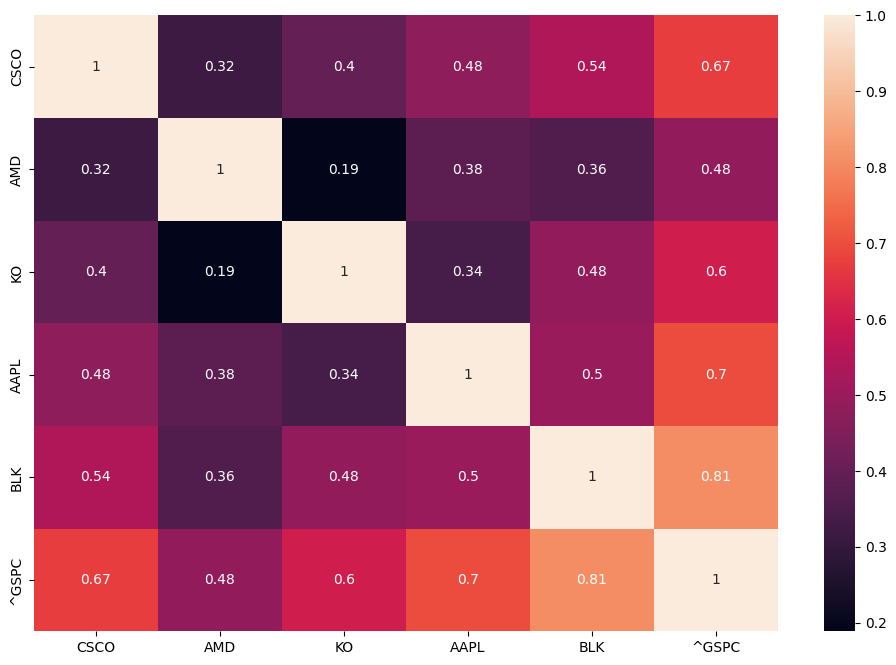

In [20]:
dataset = taxas_retorno.copy()

dataset.drop(labels = ['Date'], axis=1, inplace=True)
plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(), annot=True); 
##plt.imshow(dataset.corr(), cmap='hot', interpolation='nearest')
##plt.show()

### d) Monte um conjunto de carteiras simuladas da fronteira eficiente: Voce deve simular um grande numero de carteiras aleatorias que contenham as acoes selecionadas e calcular o retorno e o risco de cada carteira. Voce deve usar a simulacao Monte Carlo para criar 50.000 carteiras simuladas e plotar a fronteira eficiente de Markowitz. Isso permitira a voce identificar a carteira com o melhor ındice de Sharpe.

In [21]:
acoes_port = acoes_df.copy()
acoes_port.drop(labels = ['^GSPC'], axis=1, inplace=True)
log_ret = acoes_port.copy()
log_ret.drop(labels = ["Date"], axis = 1, inplace = True)
log_ret = np.log(log_ret/log_ret.shift(1))
np.random.seed(123)
num_ports = 50000 #simula 10000 portifolios
all_weights = np.zeros((num_ports, len(acoes_port.columns[1:])))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

In [22]:
for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(5))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum((log_ret.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [23]:
print("Max Sharpe Ratio: {}". format(sharpe_arr.max()))
print("Local do Max Sharpe Ratio: {}". format(sharpe_arr.argmax()))

Max Sharpe Ratio: 0.04991623879336315
Local do Max Sharpe Ratio: 7123


### e) Identifique a carteira com melhor ındice de Sharpe: Voce deve escolher a carteira com o melhor ındice de Sharpe, que e uma medida de risco-retorno. Voce deve plotar a carteira selecionada no grafico das carteiras simuladas e destacar a fronteira eficiente de Markowitz.

In [24]:
# Pesos do Portfólio do Max Sharpe Ratio
melhores_pesos = all_weights[7123,:]
print(melhores_pesos)

[0.02594791 0.10828129 0.07554781 0.66821482 0.12200817]


In [25]:
# salvando os dados do Max Sharpe Ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print(max_sr_ret*100)
print(max_sr_vol*100)

0.07904420436842305
1.5835368665423715


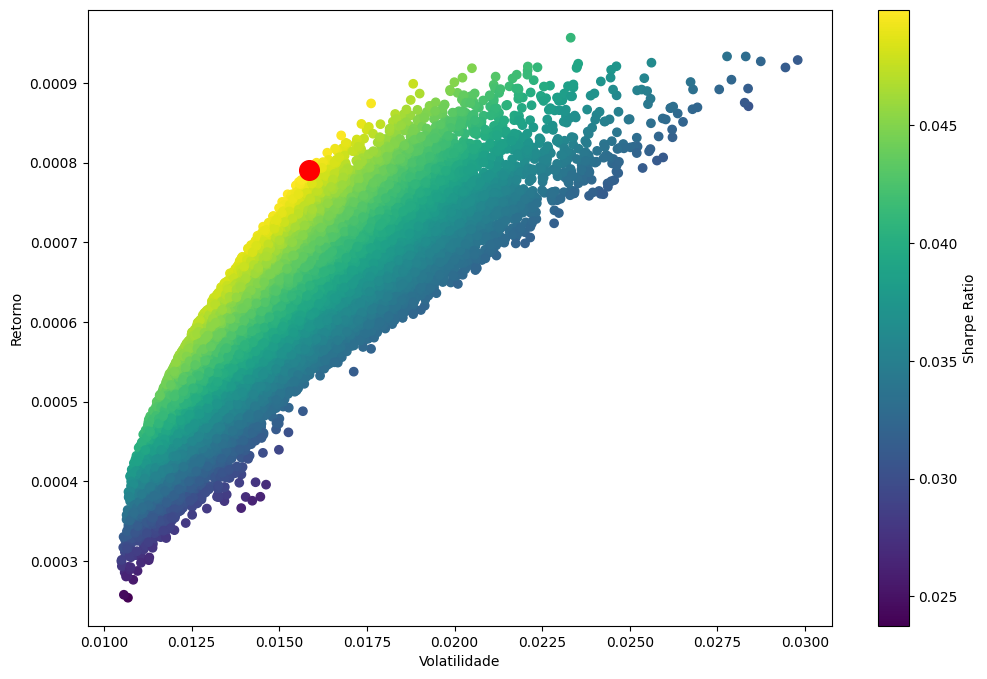

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=200) # black dot
plt.show()

In [27]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [28]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1))
init_guess = ((0.2),(0.2),(0.2),(0.2),(0.2))

In [29]:
op_results = optimize.minimize(neg_sharpe, init_guess, method="SLSQP", bounds= bounds, constraints=cons)
print(op_results)

     fun: -0.05033553070810608
     jac: array([ 3.33558861e-03, -2.14623287e-05,  5.43000177e-04,  7.26431608e-06,
       -4.51495405e-04])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.55158385e-18, 1.09700862e-01, 2.60754020e-02, 8.24808963e-01,
       3.94147735e-02])


In [34]:
frontier_y = np.linspace(0.000, 0.0007, 5000)

In [35]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [36]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = optimize.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

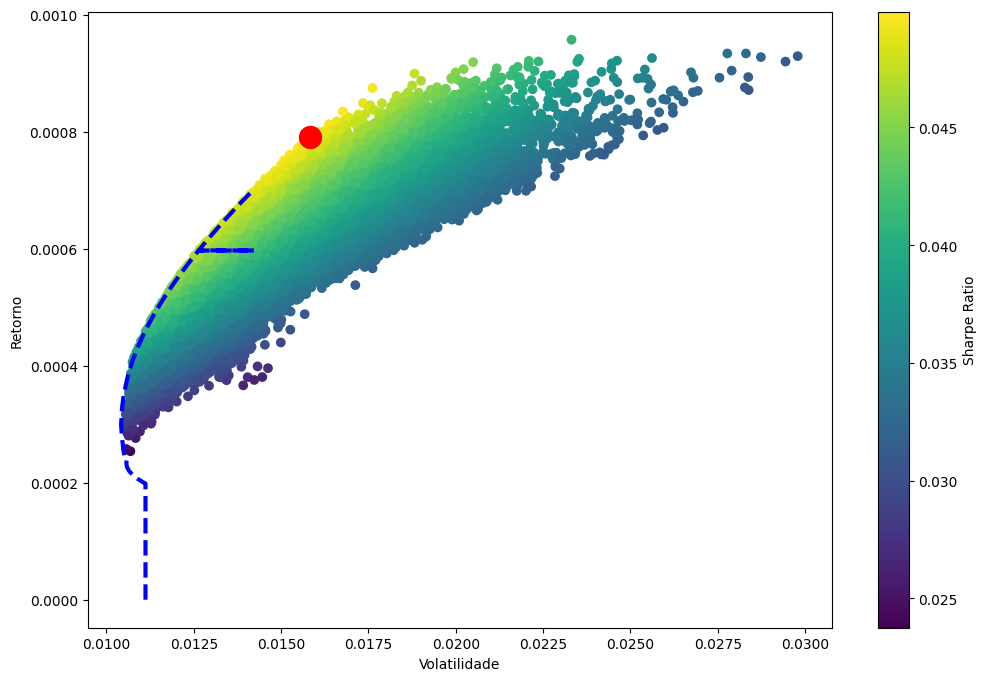

In [37]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.plot(frontier_x,frontier_y, 'b--', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=250)
plt.show()

In [38]:
acoes_port = acoes_df.copy()
acoes_port.drop(labels = ['^GSPC'], axis=1, inplace=True)
acoes_port

Date       CSCO         AMD         KO        AAPL         BLK
0     2012-01-03  18.629999    5.480000  35.070000   14.686786  181.270004
1     2012-01-04  18.990000    5.460000  34.849998   14.765714  179.960007
2     2012-01-05  18.920000    5.460000  34.685001   14.929643  179.330002
3     2012-01-06  18.850000    5.430000  34.465000   15.085714  179.130005
4     2012-01-09  18.969999    5.590000  34.465000   15.061786  179.250000
...          ...        ...         ...        ...         ...         ...
2906  2023-07-24  53.110001  110.610001  62.459999  192.750000  756.580017
2907  2023-07-25  53.599998  113.000000  62.250000  193.619995  746.020020
2908  2023-07-26  53.220001  110.089996  63.049999  194.500000  743.159973
2909  2023-07-27  53.000000  111.099998  62.439999  193.220001  729.070007
2910  2023-07-28  52.090000  112.959999  62.480000  195.830002  738.340027

[2911 rows x 6 columns]

### f) Ilustre a evolucao de seu patrimonio: Voce pode simular o desempenho da carteira selecionada ao longo do tempo e calcular o retorno esperado. Voce deve entao plotar a evolucao do patrimonio com um investimento inicial de R$35.000,00.

In [40]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
    dataset = dataset.copy()
    if seed != 0:
        np.random.seed(seed)
    if len(melhores_pesos) > 0:
        pesos = melhores_pesos
    else:  
        pesos = np.random.random(len(dataset.columns) - 1)
        #print(pesos, pesos.sum())
        pesos = pesos / pesos.sum()
        #print(pesos, pesos.sum())
    colunas = dataset.columns[1:] 
    #print(colunas)
    for i in colunas:
        dataset[i] = (dataset[i] / dataset[i][0])
    for i, acao in enumerate(dataset.columns[1:]):
    #print(i, acao)
        dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total
    dataset['soma valor'] = dataset.iloc[:, 1:].sum(axis=1)
    datas = dataset['Date']
    #print(datas)
    dataset.drop(labels = ['Date'], axis = 1, inplace = True)
    dataset['taxa retorno'] = 0.0
    for i in range(1, len(dataset)):
        dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1]) * 100
    acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos})

    return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [41]:
print(acoes_port.dtypes)

Date     object
CSCO    float64
AMD     float64
KO      float64
AAPL    float64
BLK     float64
dtype: object


In [42]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(acoes_port, 35000, 0, melhores_pesos)
dataset

CSCO           AMD           KO           AAPL           BLK  \
0      908.176808   3789.845131  2644.173418   23387.518607   4270.286035   
1      925.726149   3776.013593  2627.585982   23513.205054   4239.425638   
2      922.313798   3776.013593  2615.145693   23774.248708   4224.584236   
3      918.901447   3755.266121  2598.558257   24022.780211   4219.872788   
4      924.751165   3865.918757  2598.558257   23984.675783   4222.699585   
...           ...           ...          ...            ...           ...   
2906  2589.010897  76495.396140  4709.297711  306938.788659  17823.208504   
2907  2612.897355  78148.266125  4693.464406  308324.185533  17574.440318   
2908  2594.373216  76135.772846  4753.781964  309725.522149  17507.064493   
2909  2583.648577  76834.267675  4707.789736  307687.227597  17175.138731   
2910  2539.287826  78120.602389  4710.805686  311843.442517  17393.518132   

         soma valor  taxa retorno  
0      35000.000000      0.000000  
1      35081.956417      0.233887  
2      35312.306028      0.654458  
3      35515.378823      0.573429  
4      35596.603547      0.228442  
...             ...           ...  
2906  408555.701911      0.295655  
2907  411353.253737      0.682408  
2908  410716.514667     -0.154911  
2909  408988.072317     -0.421724  
2910  414607.656550      1.364667  

[2911 rows x 7 columns]

In [43]:
acoes_pesos

Ações     Pesos
0  CSCO  0.025948
1   AMD  0.108281
2    KO  0.075548
3  AAPL  0.668215
4   BLK  0.122008

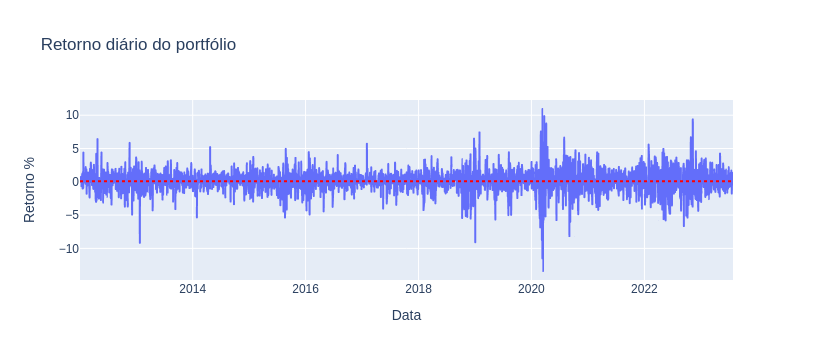

In [44]:
figura = px.line(x = datas, y = dataset['taxa retorno'], title = 'Retorno diário do portfólio',
                labels=dict(x="Data", y="Retorno %"))
figura.add_hline(y = dataset['taxa retorno'].mean(), line_color="red", line_dash="dot", )
figura.show()

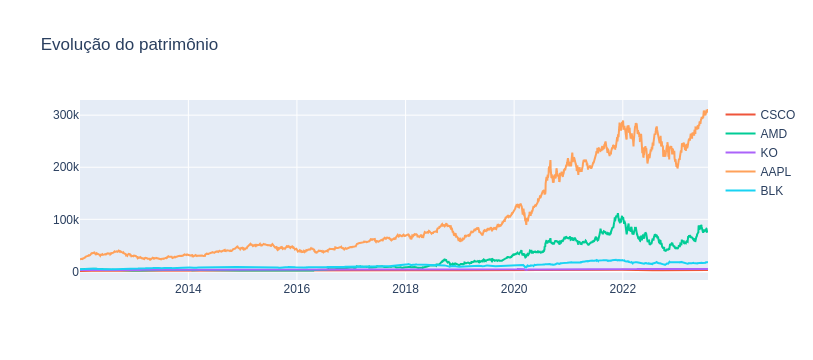

In [45]:
figura = px.line(title = 'Evolução do patrimônio')
for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
    figura.add_scatter(x = datas, y = dataset[i], name = i)
figura.show()

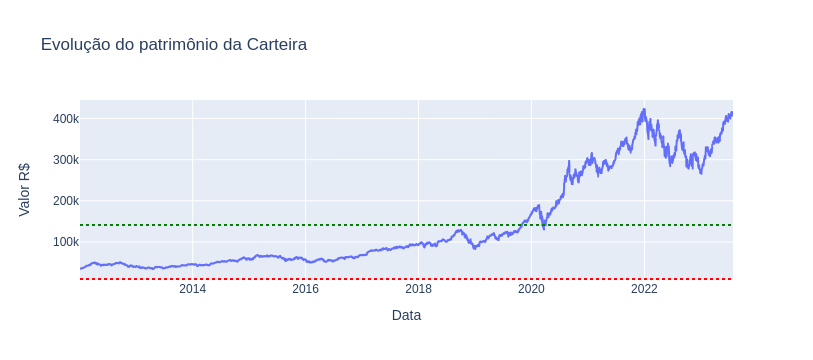

In [46]:
figura = px.line(x = datas, y = dataset['soma valor'], 
                 title = 'Evolução do patrimônio da Carteira',
                 labels=dict(x="Data", y="Valor R$"))
figura.add_hline(y = dataset['soma valor'].mean(), 
                 line_color="green", line_dash="dot", )
figura.add_hline(y = 10000, 
                 line_color="red", line_dash="dot", )
figura.show()

### g) Monte a avaliacao de risco da carteira: Voce deve usar a simulacao Monte Carlo para calcular o Value at Risk (VaR) da carteira selecionada, que e uma medida de risco que quantifica a perda potencial em uma carteira em um nıvel de confianca especıfico. Voce calcular o VaR para um nıvel de perda aceitavel de retorno e tambem para um nıvel maximo de perda aceitavel em valor em reais. 

In [57]:
acoes_var = acoes_df[['Date', 'CSCO', 'AMD', 'KO', 'AAPL', 'BLK']].copy()
acoes_var

Date       CSCO         AMD         KO        AAPL         BLK
0     2012-01-03  18.629999    5.480000  35.070000   14.686786  181.270004
1     2012-01-04  18.990000    5.460000  34.849998   14.765714  179.960007
2     2012-01-05  18.920000    5.460000  34.685001   14.929643  179.330002
3     2012-01-06  18.850000    5.430000  34.465000   15.085714  179.130005
4     2012-01-09  18.969999    5.590000  34.465000   15.061786  179.250000
...          ...        ...         ...        ...         ...         ...
2906  2023-07-24  53.110001  110.610001  62.459999  192.750000  756.580017
2907  2023-07-25  53.599998  113.000000  62.250000  193.619995  746.020020
2908  2023-07-26  53.220001  110.089996  63.049999  194.500000  743.159973
2909  2023-07-27  53.000000  111.099998  62.439999  193.220001  729.070007
2910  2023-07-28  52.090000  112.959999  62.480000  195.830002  738.340027

[2911 rows x 6 columns]

In [158]:
acoes = ['CSCO', 'AMD', 'KO', 'AAPL', 'BLK']


acoes_df = pd.DataFrame()

for acao in acoes:
    acoes_df[acao] = (yf.download(acao, start='2012-01-01',  end='2023-07-31')['Close']).pct_change()
acoes_df.index = acoes_df.index.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [160]:
acoes_df

CSCO       AMD        KO      AAPL       BLK
Date                                                        
2012-01-03       NaN       NaN       NaN       NaN       NaN
2012-01-04  0.019324 -0.003650 -0.006273  0.005374 -0.007227
2012-01-05 -0.003686  0.000000 -0.004734  0.011102 -0.003501
2012-01-06 -0.003700 -0.005495 -0.006343  0.010454 -0.001115
2012-01-09  0.006366  0.029466  0.000000 -0.001586  0.000670
...              ...       ...       ...       ...       ...
2023-07-24  0.009120 -0.003064  0.000320  0.004220  0.007148
2023-07-25  0.009226  0.021607 -0.003362  0.004514 -0.013958
2023-07-26 -0.007090 -0.025752  0.012851  0.004545 -0.003834
2023-07-27 -0.004134  0.009174 -0.009675 -0.006581 -0.018960
2023-07-28 -0.017170  0.016742  0.000641  0.013508  0.012715

[2911 rows x 5 columns]

In [136]:
weights = np.array([0.025948, 0.108281, 0.075548, 0.668215, 0.122008])
weights = weights / np.sum(weights)
acoes_pesos

Ações     Pesos
0  CSCO  0.025948
1   AMD  0.108281
2    KO  0.075548
3  AAPL  0.668215
4   BLK  0.122008

In [59]:
investimento_incial = 35000

In [161]:
cov_matrix = acoes_df.cov()
cov_matrix

CSCO       AMD        KO      AAPL       BLK
CSCO  0.000252  0.000182  0.000070  0.000138  0.000144
AMD   0.000182  0.001318  0.000075  0.000249  0.000216
KO    0.000070  0.000075  0.000123  0.000068  0.000090
AAPL  0.000138  0.000249  0.000068  0.000328  0.000152
BLK   0.000144  0.000216  0.000090  0.000152  0.000284

In [105]:
cov_matrix['portifolio'] = cov_matrix.dot(weights)

In [162]:
# Calculate mean returns for each stock
avg_rets = acoes_df.mean()

# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean) * investimento_incial

# Calculate standard deviation of investmnet
stdev_investment = investimento_incial * port_stdev

In [193]:
port_mean, port_stdev, mean_investment, stdev_investment

(0.000995948755264687,
 0.015825831602582423,
 35034.85820643426,
 553.9041060903849)

### VaR para uma confiança de 95%

In [200]:
conf_level_95 = 0.05

In [201]:
cutoff = norm.ppf(conf_level_95, mean_investment, stdev_investment)

In [202]:
var_1d_95 = investimento_incial - cutoff
var_1d_95

876.23297145182

### VaR para uma confiança de 70%

In [203]:
conf_level_70 = 0.30

In [204]:
cutoff = norm.ppf(conf_level_70, mean_investment, stdev_investment)

In [205]:
var_1d_95 = investimento_incial - cutoff
var_1d_95

255.60939079062518